<a href="https://colab.research.google.com/github/marlonrcfranco/weather-guru/blob/main/weather_guru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# weather-guru
## Will it rain tomorrow?


### Goal 🌦
Implement an algorithm that performs **next day rain prediction** by training machine learning models on the target variable `RainTomorrow`.



### Dataset 📂
The dataset contains about **10 years of daily weather observations** from various locations in **Australia**.

**`RainTomorrow`** is the target variable to be  predicted. It means - it rained the next day, this column is `Yes` if the rain that day was 1mm or more.







## Imports & Defines

In [1]:
%matplotlib inline
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from functools import partial
import plotly.express as px
!pip install portolan
import portolan

# Defines
DATASET_URL = "https://raw.githubusercontent.com/marlonrcfranco/weather-guru/main/data/weatherAUS.csv"
MODEL_PATH = "model/"

TARGET_NAME = 'RainTomorrow'

EPOCHS = 100 # The number of epochs is the number of complete passes through the training dataset. 
BATCH_SIZE = 1023 # The size of a batch must be more than or equal to one and less than or equal to the number of samples in the training dataset.
K_FOLD_SPLITS = 5
LOSS_FUNCTION = 'binary_crossentropy' # 'binary_crossentropy'. Others: 'mse': Mean Square Error, 'mae': Mean Absolute Error
LEARNING_RATE = 0.001 #0.001
NEURONS_1 = 27
NEURONS_2 = 7 # This amount of neurons in the second hidden layer forces the network to choose the most relevant features

## Fetch Data

In [2]:
weather_df = pd.read_csv(DATASET_URL,parse_dates=True)
weather_df.shape()

## Data Preprocessing

### Dataframe Info

In [3]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [4]:
weather_df.shape

(145460, 23)

### Sample

In [5]:
weather_df.sample()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
39673,2009-05-16,Williamtown,14.5,23.1,0.0,7.6,8.0,NW,61.0,NW,WNW,31.0,43.0,45.0,42.0,1011.1,1008.9,5.0,NaN,17.7,21.6,No,No


### Unique values for non-numeric columns

In [6]:
for col in weather_df:
  if not pd.api.types.is_numeric_dtype(weather_df[col]):
    print("\n-------\nColumn: "+col+" ["+str(len(weather_df[col].unique()))+" unique values]:\n")
    print(weather_df[col].unique())


-------
Column: Date [3436 unique values]:

['2008-12-01' '2008-12-02' '2008-12-03' ... '2008-01-29' '2008-01-30'
 '2008-01-31']

-------
Column: Location [49 unique values]:

['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']

-------
Column: WindGustDir [17 unique values]:

['W' 'WNW' 'WSW' 'NE' 'NNW' 'N' 'NNE' 'SW' nan 'ENE' 'SSE' 'S' 'NW' 'SE'
 'ESE' 'E' 'SSW']

-------
Column: WindDir9am [17 unique values]:

['W' 'NNW' 'SE' 'ENE' 'SW' 'SSE' 'S' 'NE' nan 'SSW' 

So there are 3436 days of observation in the dataset.

### Check for duplicated rows

In [7]:
# Check if exists duplicated rows based on all columns
duplicateRowsDF = weather_df[weather_df.duplicated()]
if len(duplicateRowsDF)!=0: print("Identical rows were found!")

# Check if exists is duplicated rows based on 'Date' column
duplicateRowsDF = weather_df[weather_df.duplicated(['Date'])]
if len(duplicateRowsDF)!=0: 
  print(len(duplicateRowsDF),"rows with the same Date were found.\n")

# Check if exists is duplicated rows based on 'Date' and 'Location' columns
duplicateRowsDF = weather_df[weather_df.duplicated(['Date','Location'])]
if len(duplicateRowsDF)!=0: 
  print(len(duplicateRowsDF),"rows with the same Date and Location were found.\n")

142024 rows with the same Date were found.



### Convert Date to datetime

In [8]:
weather_df['Date'] = pd.to_datetime(weather_df['Date'])

### Wind Cardinal directions (string) to Degrees (float)

In [9]:
weather_df['WindGustDir'] = weather_df['WindGustDir'].apply(lambda w: portolan.middle(str(w)) if str(w)!='nan' else w)
weather_df['WindDir9am'] = weather_df['WindDir9am'].apply(lambda w: portolan.middle(str(w)) if str(w)!='nan' else w)
weather_df['WindDir3pm'] = weather_df['WindDir3pm'].apply(lambda w: portolan.middle(str(w)) if str(w)!='nan' else w)

### Map 'Yes' and 'No' to infer boolean values


In [10]:
weather_df.RainToday = weather_df.RainToday.map(dict(Yes=1, No=0))
weather_df.RainTomorrow = weather_df.RainTomorrow.map(dict(Yes=1, No=0))

### Add YEAR, MONTH and DAY columns

In [11]:
weather_df['year'] = weather_df.Date.dt.year
weather_df['month'] = weather_df.Date.dt.month
weather_df['day'] = weather_df.Date.dt.day

# Drop the Date column
# It is now replaced by year, month and day columns
weather_df.drop(['Date'], axis=1, inplace=True)

### Add latitude and longitude columns

In [12]:
locator = Nominatim(user_agent="weather-guru")
# conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)

# 1 - List the unique values of Location, to further improve performance
unique_locations = pd.DataFrame()
unique_locations['description'] = weather_df['Location'].unique()
unique_locations['id'] = weather_df['Location'].unique()
unique_locations.set_index(['id'], inplace = True)
print("Total unique locations: {}".format(len(unique_locations)))

# Add 'rainfall/day' column
unique_locations['days'] = weather_df['Location'].value_counts().values
unique_locations['rainfall'] = weather_df.groupby(['Location']).sum()['Rainfall'].values
unique_locations['rainfall/day'] = unique_locations['rainfall']/unique_locations['days']

# Separate CamelCase with space to allow geocode to find the location
unique_locations['description'] = unique_locations['description'].apply(lambda loc: re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', loc)))
# Add the country to the Location in order to avoid misunderstandings
unique_locations['description'] = unique_locations['description'].apply(lambda loc: loc + ', Australia')

# 2- create improved location column (gcode)
print("Searching for locations...")
unique_locations['gcode'] =  unique_locations['description'].apply(partial(geocode, addressdetails=True))

# 3 - create point (longitude, latitude and altitude) from gcode (location) column (returns tuple)
unique_locations['point'] = unique_locations['gcode'].apply(lambda loc: tuple(loc.point) if loc else None)

# 4 - split point column into latitude, longitude and altitude columns
unique_locations[['latitude', 'longitude', 'altitude']] = pd.DataFrame(unique_locations['point'].tolist(), index=unique_locations.index)

# Verify if all the locations were found
if not unique_locations['gcode'].isnull().any(): 
  print("All the locations were found!")
else: 
  print("The current locations were not found:")
  print(unique_locations[unique_locations['gcode'].isnull()])

# Verify if all the found locations are from Australia
unique_locations['country'] = unique_locations['gcode'].apply(lambda loc: (loc.raw.get('address').get('country')) if loc else None)
if unique_locations['country'].str.contains('Australia').all():
  print("All the found locations are from Australia")

def get_lat_lon_alt_from_location(location_name):
  location_data = unique_locations.loc[location_name]
  lat = location_data['latitude']
  lon = location_data['longitude']
  alt = location_data['altitude']
  return lat,lon,alt

print("Adding latitude, longitude and altitude columns to the dataset...")
weather_df[['latitude', 'longitude', 'altitude']] = list(weather_df['Location'].apply(get_lat_lon_alt_from_location))

# Drop the Location column
# It is now replaced by latitude, longitude and altitude columns
weather_df.drop(['Location'], axis=1, inplace=True)


Total unique locations: 49
Searching for locations...
All the locations were found!
All the found locations are from Australia
Adding latitude, longitude and altitude columns to the dataset...


### Plot map (just for fun)

In [13]:
# Plot map
fig = px.scatter_geo(unique_locations,lat='latitude',lon='longitude', hover_name="description", color='rainfall/day')
fig.update_layout(title = 'Locations in the dataset', title_x=0.5)
fig.show()

### Reorder columns

In [14]:
# Reorder columns
initial_columns = ['year','month','day','latitude','longitude','altitude']
target_column = [TARGET_NAME]
middle_columns = [col for col in weather_df.columns if col not in initial_columns and col not in target_column]
columns_reordered = initial_columns + middle_columns + target_column

weather_df =  weather_df[columns_reordered]

### Proceed with data type conversion

In [15]:
# Convert data types
weather_df = weather_df.convert_dtypes()

## Data Cleaning

### Remove rows with null values in the target column

In [16]:
# There are null values (nan) in the RainTomorrow column
print("Before:\n  Unique values in the RainTomorrow column: ", weather_df.RainTomorrow.unique())
rows_before = len(weather_df)
print(" Total number of rows: [", rows_before, "]")
# Select only the not-null rows
weather_df = weather_df[weather_df.RainTomorrow.notna()]
print("\nAfter:\n  Unique values in the RainTomorrow column: ", weather_df.RainTomorrow.unique())
rows_after = len(weather_df)
print(" Total number of rows: [", rows_after, "] (", (rows_before-rows_after) , " rows removed )")

Before:
  Unique values in the RainTomorrow column:  <IntegerArray>
[0, 1, <NA>]
Length: 3, dtype: Int64
 Total number of rows: [ 145460 ]

After:
  Unique values in the RainTomorrow column:  <IntegerArray>
[0, 1]
Length: 2, dtype: Int64
 Total number of rows: [ 142193 ] ( 3267  rows removed )


### Ensure all data is float

In [17]:
for col in weather_df.columns:
  weather_df[col] = weather_df[col].astype('float32')

### Filling missing values 

In [18]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
# transform the datasetimputer.fit_transform(values)
weather_df_transformed = pd.DataFrame(imputer.fit_transform(weather_df))
weather_df_transformed.columns = weather_df.columns
weather_df_transformed.index = weather_df.index

weather_df = weather_df_transformed

### Correlation

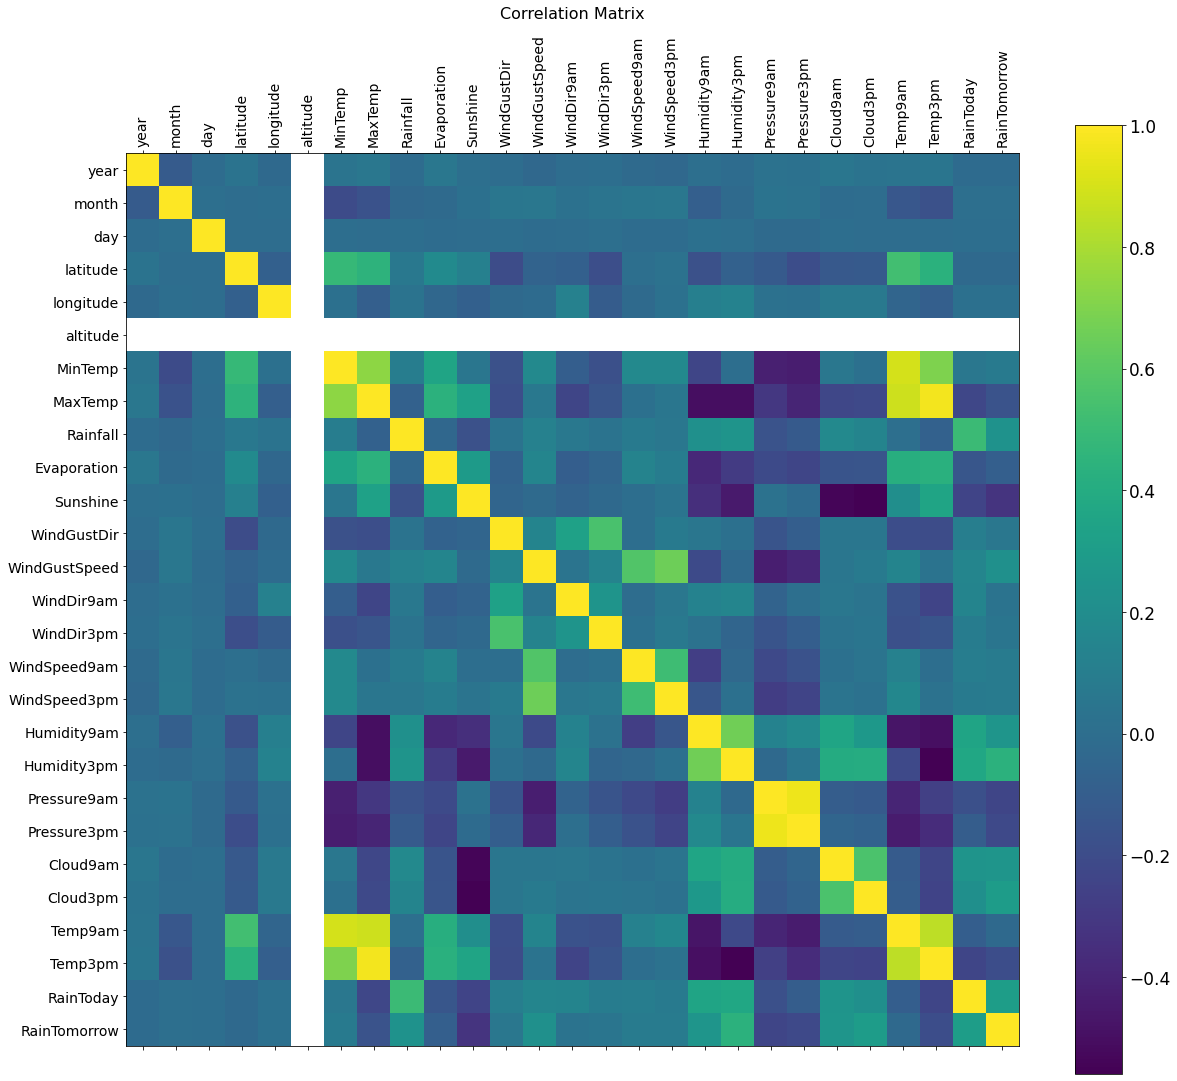

In [19]:
f = plt.figure(figsize=(20, 17))
plt.matshow(weather_df.corr(), fignum=f.number)
plt.xticks(range(weather_df.select_dtypes(['number']).shape[1]), weather_df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(weather_df.select_dtypes(['number']).shape[1]), weather_df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=17)
plt.title('Correlation Matrix', fontsize=16, pad=90);

## Feature engineering

In [20]:
values = weather_df.values

In [21]:
# Number of features is the number of columns except the target column
NUM_FEATURES = len(weather_df.columns)-1
NUM_FEATURES

26

### Normalize features

In [22]:
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(values)

### Split into input and outputs

In [23]:
target_col_idx = weather_df.columns.get_loc(TARGET_NAME)

X = values[:,0:target_col_idx].astype(float)
Y = values[:,target_col_idx]

print(X.shape,Y.shape)

(142193, 26) (142193,)


### Encode class values as integers

In [24]:
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

## Design the model

We want to predict a boolean value ('Yes' or 'No') for the target variable **`RainTomorrow`**. In this case, we need to use a **classification** model, istead of a **regression** model, wich is used to predict real-world values (e.g. `Rainfall`).

In [25]:
def create_model():
  model = Sequential(name='weather_guru')
  model.add(Dense(NEURONS_1, input_dim=NUM_FEATURES, activation='relu', name='dense_1'))
  model.add(Dense(NEURONS_2, activation='relu', name='dense_2'))
  model.add(Dense(1, activation='sigmoid', name='output'))
  adam_optmz = Adam(learning_rate=LEARNING_RATE)
  # Compile model
  model.compile(loss=LOSS_FUNCTION, optimizer=adam_optmz, metrics=['accuracy'])
  print(model.summary())
  return model

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn = create_model, epochs = EPOCHS, batch_size = BATCH_SIZE, verbose = 1)))
pipeline = Pipeline(estimators)

## Train the model and validate it

In [26]:
kfold = StratifiedKFold(n_splits=K_FOLD_SPLITS, shuffle=True)

In [27]:
%%time
results = cross_val_score(pipeline, X, encoded_Y, cv=kfold)

Model: "weather_guru"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 27)                729       
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 196       
_________________________________________________________________
output (Dense)               (None, 1)                 8         
Total params: 933
Trainable params: 933
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
112/112 [==============================] - 1s 2ms/step - loss: 0.5879 - accuracy: 0.6701
Epoch 2/100
112/112 [==============================] - 0s 1ms/step - loss: 0.3928 - accuracy: 0.8279
Epoch 3/100
112/112 [==============================] - 0s 2ms/step - loss: 0.3711 - accuracy: 0.8378
Epoch 4/100
112/112 [==============================] - 0s 1ms/step - loss: 0.3

## Final Results

In [30]:
"Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100)

'Accuracy: 85.72% (0.08%)'